# 概要
混合モデルは、潜在変数でモデルをスイッチングする構造を持っている。そのため、潜在的に多クラスあるようなデータに対して有効なモデルである。

あらかじめクラスタ構造がわかっていて、データを明に分離できる場合には問題ないが、どのような特徴でデータが分割できるか自明ではない場合、なんらかの属性によって過度に分割してデータが少なくなってしまったり、複数の異なる特徴を合わせたデータになってしまったりする。

そこで、混合モデルを使ってこのようなデータ構造をモデリングしたい。

ここでは、複数の線形回帰モデルを組み合わせて複雑なデータ構造を推論してみる。

## コンテンツ
まずは、通常の線形回帰モデルをベイズ推論により求めてみる（「ベイズ線形回帰」と呼ばれてたりします）。

次に、トイデータを作って、線形回帰モデルを複数組み合わせたモデル（ここでは、混合線形回帰モデルと呼びます）を推論してみる。

## 参考
1. 須山, 「[ベイズ推論による機械学習 入門](https://www.amazon.co.jp/dp/4061538322/ref=cm_sw_r_tw_dp_U_x_193zEbE87QG1P)」, 2017, 講談社
2. C.M.ビショップ, 「パターン認識と機械学習 上下」, 2007, シュプリンガー・ジャパン
3. Osvaldo Martin, 「Pythonによるベイズ統計モデリング」, 2018, 共立出版
3. 弊ブログ, 「[ベイズ推論により混合分布のパラメータ推論をやってみる](https://learning-with-machine.hatenablog.com/entry/2020/03/09/083000)」

In [4]:
from jax.config import config; config.update("jax_enable_x64", True)
import jax
import jax.numpy as np
import numpy as onp
import pandas as pd
import numpyro 

from scipy import stats

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
colors = onp.array(sns.color_palette().as_hex())

# 線形回帰

In [6]:
# display_png(Image('img/linear_regression1.png'))

線形回帰モデルは、機械学習の分野で頻繁に登場するモデル。

データYがデータ$X$と確率変数$W$に依存する構造である。
$X$を説明変数、$Y$を目的変数、$W$を重みパラメータなど呼ぶ場合もある。
データ$(X,Y)$は予め与えられるものであり、未知の変数$W$を$(X,Y)$のペアに基づいて推論することが目的となる。

$W$を推論したあとで、未知の入力変数$x_*$に対する$p(y_* | x_*, W, X, Y)$を推論することができる。

最尤法などでパラメータを推論した場合には、予測値は分布ではなく一点で得られる。

線形回帰のベイズ推論については、解析解を求めることができ、詳しくは参考資料を参照。
弊ブログでもソースコード付きで記事を公開している

- [ベイズ線形回帰（解析解）の実装](https://learning-with-machine.hatenablog.com/entry/2019/10/31/183000)
- [サンプリングによる近似ベイズ推論 その3（MCMC:ギブスサンプリング）](https://learning-with-machine.hatenablog.com/entry/2019/12/05/193000)

ここでは、MCMCアルゴリズムを利用した近似解を取得する。MCMCアルゴリズムは、PyMC3を利用する。

## サンプルデータ
ここでは、2次の多項式に従うサンプルデータを使って、ベイズ線形回帰のパラメータ推論を試行する。

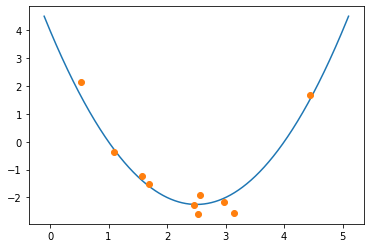

In [7]:
def polynomial(x, degree):
    """多項式
    """
    return [np.power(x, d) for d in np.arange(0, degree+1)]

def true_func(x, params=None):
    y = onp.dot(params['w'], polynomial(x, params['d']))
    return y

def observation_model(x, var=1.0, true_model_params=None):
    ty = true_func(x, params=true_model_params)
    y = onp.random.normal(ty, np.sqrt(var))
    return y

n_sample = 10
xmin,xmax = 0, 5
sample_x = xmin + (xmax-xmin)*onp.random.rand(n_sample) # 純粋にランダムにサンプル

tfunc_params = {'d':2, 'w':np.array([4.0, -5.0, 1.0])}
var_y = 0.1
sample_y = observation_model(sample_x, var=var_y, true_model_params=tfunc_params)

# plot
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)
xs = np.linspace(xmin-0.1, xmax+0.1, 1000)
tys = list(map(lambda x:true_func(x, params=tfunc_params), xs))
ax.plot(xs, tys, '-')
ax.plot(sample_x, sample_y, 'o')

## モデル構築
線形回帰モデルは先に掲載したグラフィカルモデルに基づく。

各変数の確率分布を定義する必要があり、ここでは、以下のように、観測モデルにガウスノイズを仮定したモデルを構築する。

$$
\begin{aligned}
& p(Y|X,W) = \mathcal{N}(y_n | f(W, X), \tau) \\
& f(W, X) = \sum^M_{m=0} w_m \phi_m(x) \\
& p(W) = \mathcal{N}(w | \mu, \Lambda) \\
& p(\tau) = \mathrm{Gamma}(\tau | \alpha, \beta)
\end{aligned}
$$

ここで$\phi_m(x)$は、$m=\{0, 1, \cdots, M\}$で、$x^m$を表す。

基底関数の解説など、線形回帰について詳しくは、弊ブログの以下の記事などを参照。

- [ベイズ線形回帰（解析解）の実装](https://learning-with-machine.hatenablog.com/entry/2019/10/31/183000)
- [サンプリングによる近似ベイズ推論 その3（MCMC:ギブスサンプリング）](https://learning-with-machine.hatenablog.com/entry/2020/03/06/225552)

このモデルは、観測モデルが平均$f(W, X)$のガウス分布であり、ガウス分布のパラメータ推論とほぼ同様のモデルとなる。
ガウス分布のパラメータ推論については、弊ブログの以下の記事などを参照。

- [ベイズ推論により混合分布のパラメータ推論をやってみる　〜まずはガウス分布のパラメータ推論〜](https://learning-with-machine.hatenablog.com/entry/2020/03/06/225552)

以下の例では、M=3、つまり3次の多項式で上記のトイデータを回帰することを試みる。
正解はM=2だが、冗長なモデルを使って推論を試行する。

In [69]:
# 多項式の次数
nd = 3

# 事前に基底関数をかけて特徴抽出したデータを作る
sample_x_feature = np.array(polynomial(x=sample_x, degree=nd))
print(sample_x_feature.shape)

(4, 10)


In [70]:
def model(obsdata_x,obsdata_y):
    tau = numpyro.sample('tau', 
                         numpyro.distributions.Gamma(concentration=1.0,rate=0.1))
    ws = numpyro.sample('w',
                        numpyro.distributions.Normal(0.,10),sample_shape=(4,))
    
    y = numpyro.deterministic('y',np.dot(ws,np.array(polynomial(x=obsdata_x,degree=3))))
    
    numpyro.sample("y_obs", 
                   numpyro.distributions.Normal(y, 1/tau), obs=obsdata_y)

## パラメータ推論

In [71]:
num_warmup, num_samples = 500, 2000

# Run NUTS.
kernel = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(jax.random.PRNGKey(0),obsdata_x=sample_x,obsdata_y=sample_y)

sample: 100%|██████████| 2500/2500 [00:06<00:00, 392.22it/s, 411 steps of size 1.04e-02. acc. prob=0.92] 


In [72]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       tau      2.91      0.78      2.87      1.63      4.20    409.49      1.00
      w[0]      3.50      1.75      3.59      0.49      6.19    295.48      1.00
      w[1]     -4.19      2.30     -4.26     -8.23     -0.74    277.46      1.00
      w[2]      0.67      0.90      0.70     -0.90      2.04    276.31      1.00
      w[3]      0.04      0.11      0.03     -0.12      0.22    282.63      1.00

Number of divergences: 1


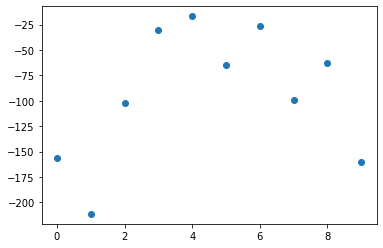

In [73]:
trace_model = numpyro.handlers.trace(numpyro.handlers.seed(model, jax.random.PRNGKey(0)))
prior_Y = trace_model.get_trace(sample_x,None)['y_obs']
plt.plot(prior_Y["value"], "o")

## 事後分布からの予測
推論結果として、パラメータWの事後分布が得られる。事後分布から数点をサンプリングして推論された関数を描画する。
また、関数の期待値（推論結果）を合わせて描画する。

In [74]:
samples = mcmc.get_samples()
tau_post = samples['tau']
w_post = samples['w']

x_test = np.linspace(-1, 6, 100)
x_test_feature = np.array(polynomial(x=x_test, degree=nd))
y_pred_dist = np.dot(w_post, x_test_feature)
y_pred = y_pred_dist.mean(axis=0) # モンテカルロ積分

(array([  4.,  16., 150., 617., 811., 317.,  72.,  10.,   1.,   2.]),
 array([-0.42546562, -0.31669105, -0.20791649, -0.09914192,  0.00963265,
         0.11840722,  0.22718178,  0.33595635,  0.44473092,  0.55350549,
         0.66228005]),
 <a list of 10 Patch objects>)

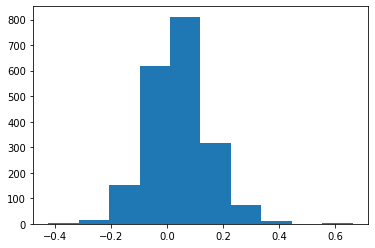

In [75]:
plt.hist(samples['w'][:,4])

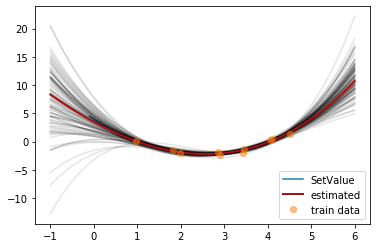

In [76]:
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)

ax.plot(xs, tys, '-', label='SetValue')

rand_idxs = onp.random.randint(0, w_post.shape[0], 100)
for i in rand_idxs:
    y_test = np.dot(w_post[i], x_test_feature)
    ax.plot(x_test, y_test, '-', c='#000000', alpha=0.1)
ax.plot(x_test, y_pred, '-', c='#AA1010', lw=2, label='estimated')
ax.plot(sample_x, sample_y, 'o', alpha=0.5, label='train data')
ax.legend()

ベイズ推論された関数。グレーの薄い線は事後分布からサンプルした関数を描画したもの。赤線は関数の推論結果(期待値)を描画したもの。見えにくいが青い線で設定値を描画している。
図から、概ね設定値を推測できていることがわかる。しかし、学習に使ったデータから離れた領域ではグレーの線がバラついており、予測の不確かさを示している。

# 混合線形回帰
次に、上記の線形回帰モデルを複数組み合わせて複雑なデータ構造を推論してみる。

## 混合モデル


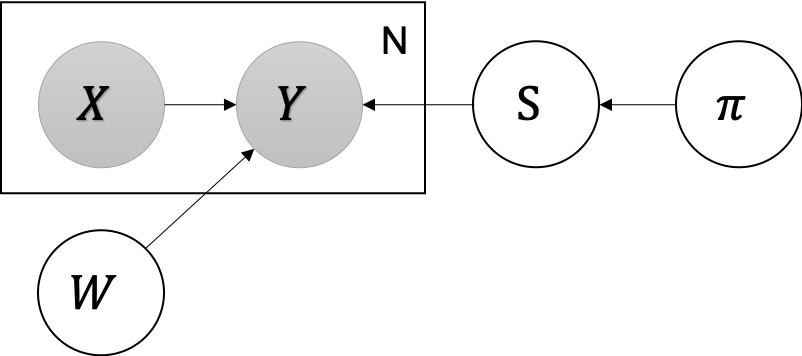

In [13]:
display_png(Image('img/mixture_linear_regression1.png'))

混合モデルについては、先に挙げた参考資料や、弊ブログの以下の記事を参照。
- [ベイズ推論により混合分布のパラメータ推論をやってみる　〜ガウス混合分布のパラメータ推論とクラスタリング〜](https://learning-with-machine.hatenablog.com/entry/2020/03/09/083000)

混合モデルとは、モデルが複数あり、それらのモデルを潜在変数$s$で切り替える構造のモデルである。
クラスタリングのように、複数のクラスがあるが各クラスのデータを事前に分離できない場合などに用いられる。

今回は線形モデルが複数組み合わさったモデルを考える。

線形モデルについては、上記の通りであり、観測される変数$y$が潜在変数$s$で切り替わる。
潜在変数$s$がどの程度選択されるかなどは$\pi$に依存する。

$$
\begin{aligned}
& p(Y|X,W,S) = \prod^K_{k=1} \mathcal{N}(y_n | f(W_k, x_n), \tau_k)^{s_k} \\
& f(W, X) = \sum^M_{m=0} w_m \phi_m(x) \\
& p(W) = \mathcal{N}(w | \mu, \Lambda) \\
& p(\tau) = \mathrm{Gamma}(\tau | \alpha, \beta) \\
& p(S|\pi) = \mathrm{Cat}(s | \pi) \\
& p(\pi) = \mathrm{Dir}(\pi | \alpha)
\end{aligned}
$$

上記の線形回帰モデルと、[前回のブログ](https://learning-with-machine.hatenablog.com/entry/2020/03/09/083000)で扱った混合モデルを組み合わせただけ。

## サンプルデータ
トイデータとして、先の例と同様に、二次関数に従うデータをサンプルする。
混合モデルなので、二つの異なる二次関数からデータをサンプルする。
なお、混ぜる関数は二次関数に限らず、また、同じ次数である必要もない。

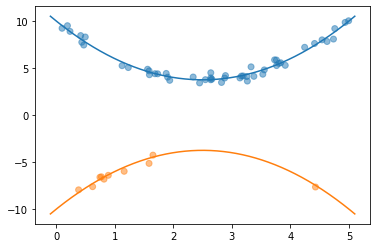

In [8]:
xmin,xmax = 0, 5
n_sample1 = 50
tfunc_params1 = {'d':2, 'w':onp.array([10.0, -5.0, 1.0])}
var_y1 = 0.1
sample_x1 = xmin + (xmax-xmin)*onp.random.rand(n_sample1)
sample_y1 = observation_model(sample_x1, var=var_y1, true_model_params=tfunc_params1)
cat_1 = np.ones(n_sample1) * 0
sample1 = np.stack([sample_x1, sample_y1, cat_1], axis=1)

n_sample2 = 10
tfunc_params2 = {'d':2, 'w':np.array([-10.0, 5.0, -1.0])}
#tfunc_params2 = {'d':2, 'w':np.array([-4.0, 5.0, -1.0])}
var_y2 = 0.1
sample_x2 = xmin + (xmax-xmin)*onp.random.rand(n_sample2)
sample_y2 = observation_model(sample_x2, var=var_y2, true_model_params=tfunc_params2)
cat_2 = np.ones(n_sample2) * 1
sample2 = np.stack([sample_x2, sample_y2, cat_2], axis=1)

samples = onp.concatenate([sample1, sample2], axis=0)
onp.random.shuffle(samples) # 一応、データの順番をランダムにソートする

# plot
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)
xs = np.linspace(xmin-0.1, xmax+0.1, 1000)
tys = true_func(xs, params=tfunc_params1)
ax.plot(xs, tys, '-', color=colors[0])
tys = true_func(xs, params=tfunc_params2)
ax.plot(xs, tys, '-', color=colors[1])
ax.scatter(samples[:,0], samples[:,1], c=colors[samples[:,2].astype('int')], alpha=0.5)

得られたデータだけを観測するこのようになる。

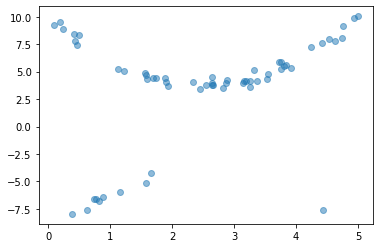

In [9]:
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)

ax.scatter(samples[:,0], samples[:,1], alpha=0.5)

## モデル構築
モデルは[前回のブログ](https://learning-with-machine.hatenablog.com/entry/2020/03/09/083000)で扱った混合モデルの例をそのまま拡張しただけである。
なお、混合モデルを扱った時の議論で、潜在変数$s$を周辺化除去することで、推論計算が非常に効率化することがわかっている。
ここでも、PyMC3のMixture APIを利用して、潜在変数を周辺化除去して計算を実行する。

In [7]:
def Model_mixture(obs_x,obs_y):
    pi = numpyro.sample('pi',numpyro.distributions.Dirichlet(np.ones(2)))
    S = numpyro.distributions.CategoricalProbs(pi).sample(jax.random.PRNGKey(0),obs_x.shape)
    comp_dist = []
    for k in range(2):
        tau = numpyro.sample(f'tau{k}',numpyro.distributions.Gamma(concentration=1.0,rate=0.1))
        ws = numpyro.sample(f'w{k}',numpyro.distributions.Normal(0,10),sample_shape=(4,))
        y = numpyro.deterministic(f'y{k}',np.dot(ws,np.array(polynomial(x=obs_x,degree=3))))
        comp_dist.append(numpyro.distributions.Normal(y,1/tau))
    
    
    numpyro.sample(f'y_obs0',comp_dist[0],obs=obs_y)

In [10]:
def Model(obs_x,obs_y):
    pi = numpyro.sample('pi',numpyro.distributions.Dirichlet(np.ones(2)))
    with numpyro.plate('components', 2):
        tau = numpyro.sample(f'tau',numpyro.distributions.Gamma(concentration=1.0,rate=0.1))
        ws = numpyro.sample(f'w',numpyro.distributions.Normal(0,10),sample_shape=(4,1))
    
#     S = numpyro.distributions.CategoricalProbs(pi).sample(jax.random.PRNGKey(2),sample_shape=obs_x.shape)
#     obs = numpyro.sample('obs', 
#                          numpyro.distributions.Normal(np.dot(ws[:,0],np.array(polynomial(x=obs_x[S>0.5],degree=3))),1/tau[0]),
#                          obs=obs_y[S>0.5])
    with numpyro.plate('data', obs_x.shape[0]):
        S = numpyro.sample('s',numpyro.distributions.CategoricalProbs(pi))
        obs = numpyro.sample('obs', 
                              numpyro.distributions.Normal(np.dot(ws[:,S],np.array(polynomial(x=obs_x,degree=3))),1/tau[S]),
                              obs=obs_y)

def guide(obs_x):
    # muの変分パラメータと近似分布
    pi = numpyro.param('pi',numpyro.distributions.Dirichlet(np.ones(2)))
    with numpyro.plate('components', 2):
        tau = numpyro.sample(f'tau',numpyro.distributions.Gamma(concentration=1.0,rate=0.1))
        ws = numpyro.sample(f'w',numpyro.distributions.Normal(0,10),sample_shape=(4,1))
    
    with numpyro.plate('data', obs_x.shape[0]):
        S = numpyro.sample('s',numpyro.distributions.CategoricalProbs(pi))
    

## パラメータ推論

In [14]:
num_warmup, num_samples = 3000, 5000

# Run NUTS.
optim = numpyro.optim.Adam({'lr': 0.2, 'betas': [0.8, 0.99]})
elbo = numpyro.infer.ELBO(max_plate_nesting=1)
svi = numpyro.infer.SVI(Model, guide, optim, loss=elbo)

n_steps = 500
# do gradient steps
for step in range(n_steps):
    svi.step(da)

# kernel = numpyro.infer. (Model)
# mcmc = numpyro.infer.MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
# mcmc.run(jax.random.PRNGKey(0),obs_x=np.array(samples[:,0]),obs_y=np.array(samples[:,1]))

In [82]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     pi[0]      0.58      0.25      0.58      0.23      1.00   1292.72      1.00
     pi[1]      0.42      0.25      0.42      0.00      0.77   1292.72      1.00
    tau[0]      0.25      0.02      0.24      0.21      0.29   2690.23      1.00
    tau[1]     10.19      9.73      7.33      0.00     23.28   3961.97      1.00
    w[0,0]      9.47      1.80      9.48      6.55     12.38   1212.22      1.00
    w[0,1]     -0.10     10.22      0.14    -16.42     16.91   3108.32      1.00
    w[1,0]     -5.78      3.49     -5.78    -11.37      0.14    930.20      1.00
    w[1,1]      0.01      9.77     -0.10    -15.65     16.38   3297.14      1.00
    w[2,0]      1.44      1.73      1.43     -1.55      4.13    951.99      1.00
    w[2,1]      0.04     10.01      0.09    -17.25     15.34   3371.20      1.00
    w[3,0]     -0.11      0.24     -0.10     -0.50      0.30   1049.78      1.00
    w[3,1]      0.23     10

## 事後分布からの予測
推論結果の可視化のため、得られた関数を描画する。
描画については、先の線形回帰の場合と同じである。

In [83]:
samples_post = mcmc.get_samples()
tau_post = samples_post['tau']
w_post = samples_post['w']

x_test = np.linspace(-1, 6, 100)
x_test_feature = np.array(polynomial(x=x_test, degree=3))

In [84]:
w_post[0].shape

(4, 2)

(-10, 10)

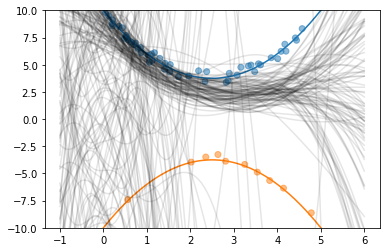

In [85]:
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)

tys = true_func(xs, params=tfunc_params1)
ax.plot(xs, tys, '-', color=colors[0])
tys = true_func(xs, params=tfunc_params2)
ax.plot(xs, tys, '-', color=colors[1])
ax.scatter(samples[:,0], samples[:,1], c=colors[samples[:,2].astype('int')], alpha=0.5)

rand_idxs = onp.random.randint(0, w_post.shape[0], 100)
for i in rand_idxs:
    y_test = np.dot(w_post[i].T, x_test_feature)
    for k in range(2):
        ax.plot(x_test, y_test[k], '-', c='#000000', alpha=0.1)
        
ax.set_ylim([-10,10])
# ax.plot(x_test, y_pred, '-', c='#AA1010', lw=2, label='estimated')
# ax.plot(sample_x, sample_y, 'o', alpha=0.5, label='train data')
# ax.legend()

In [47]:
def pred_lr(x, w, degree):
    x_feature = np.array(polynomial(x=x, degree=degree))
    y_dist = np.dot(w, x_feature)
    y_pred = y_dist.mean(axis=0) # モンテカルロ積分
    return y_pred

In [51]:
def plot_sample_post(x, w, degree, ax, n_sample=100, c='#000000', alpha=0.1):
    rand_idxs = np.random.randint(0, w.shape[0], n_sample)
    x_feature = np.array(polynomial(x=x, degree=degree))
    for i in rand_idxs:
        y_pred = np.dot(w[i], x_feature)
        ax.plot(x, y_pred, '-', c=c, alpha=alpha)

NameError: name 'tr_mlr' is not defined

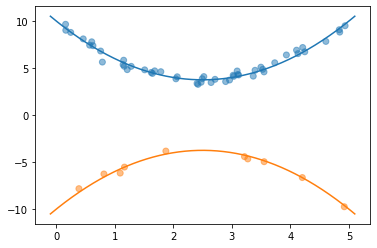

In [32]:
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)

xs = np.linspace(xmin-0.1, xmax+0.1, 1000)
tys = true_func(xs, params=tfunc_params1)
ax.plot(xs, tys, '-', color=colors[0], label='SetValue_0')
tys = true_func(xs, params=tfunc_params2)
ax.plot(xs, tys, '-', color=colors[1], label='SetValue_1')
ax.scatter(samples[:,0], samples[:,1], c=colors[samples[:,2].astype('int')], alpha=0.5)

# componet0
x_test = np.linspace(-1, 6, 100)
w_post = tr_mlr['w0']
y_pred = pred_lr(x_test, w_post, degree=nd)

plot_sample_post(x_test, w_post, nd, ax, c=colors[2])
ax.plot(x_test, y_pred, color=colors[2], lw=2, label='estimated_0')

# componet1
w_post = tr_mlr['w1']
y_pred = pred_lr(x_test, w_post, degree=nd)

plot_sample_post(x_test, w_post, nd, ax, c=colors[3])
ax.plot(x_test, y_pred, color=colors[3], lw=2, label='estimated_1')

ax.legend()

推論された関数。緑と赤の線が推論した線形モデルの各コンポーネントを示している。薄い線は事後分布からサンプルした関数を描画したもの。太い実線は関数の推論結果(期待値)を描画したもの。見えにくいが、設定値も合わせて描画している。
図から、概ね設定値を推測できていることがわかる。学習に使ったデータがない領域は推論結果がバラついていることがわかるまた、下の方のコンポーネントは学習に使うデータが少なかったため、推論のブレがより大きく不確かな度合いが大きいことがわかる。
